In [60]:
import os
import os.path as op
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [29]:
def get_label(path):
    x = path.split('.')[0].split('-')[0]
    return x
get_label('AC_L-0.npy')

'AC_L'

In [72]:
SL_PATH = "/Users/aarya/Atlas/tracks/commisural/slines"
labels = [get_label(f) for f in os.listdir(SL_PATH) if not f.startswith('.')]
len(labels)

2117

(256, 556)

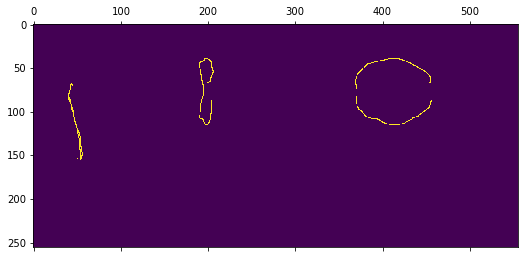

In [33]:
paths = [os.path.join(SL_PATH, f) for f in os.listdir(SL_PATH) if not f.startswith('.')]
foo = np.load(paths[0])
plt.matshow(foo)
foo.shape

(256, 556)

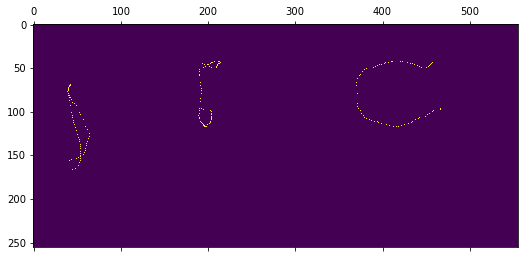

In [58]:
baz = np.load(paths[22])
plt.matshow(baz)
baz.shape

In [54]:
shape = (len(labels), foo.shape[0], foo.shape[1])
commisural_slines = np.zeros(shape)

In [55]:
idx = 0
for path in paths:
    foo = np.load(path)
    commisural_slines[idx] = foo
    idx += 1

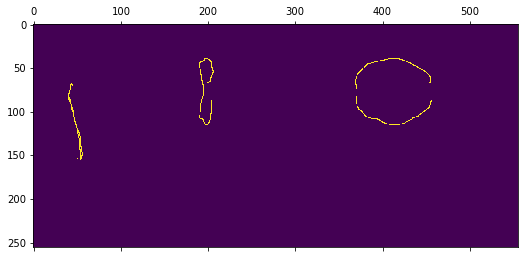

In [56]:
plt.matshow(commisural_slines[0])

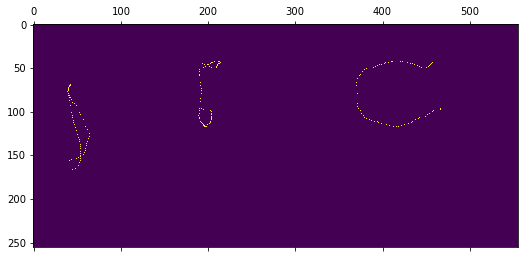

In [59]:
plt.matshow(commisural_slines[22])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(commisural_slines, labels, test_size = 0.15)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1767)

In [67]:
X_train.shape

(1481, 256, 556)

In [68]:
X_valid.shape

(318, 256, 556)

In [69]:
X_test.shape

(318, 256, 556)

In [75]:
import keras.models as km
from keras.layers import (Convolution2D, MaxPooling2D, Convolution3D,
                          MaxPooling3D, Flatten, Dense, Input, UpSampling2D,
                          UpSampling3D)
from keras.layers.merge import Concatenate


def vgg16(img_x, img_y, n_classes, img_z=None, n_channels=1,
          pool_dim=2, kernel_dim=3, stride=2):
    """
    The VGG16 architecture described in [1]_.
    Parameters
    ----------
    img_x, img_y : int
        Number of rows and columns in each image to be fed in as inputs.
    n_classes : int
        How many classes do we want to distinguish.
    img_z : int, optional
        Number of images in a stack, for 3D images. Default: 2D images
    n_channels: int, optional.
        Number of channels in the images. Default: 1.
    Returns
    -------
    model : an uncompiled :class:`km.Model` class instance.
    """
    if img_z is None:
        inputs = Input(shape=(img_x, img_y, n_channels))
        kernel_dims = (kernel_dim, kernel_dim)
        pool_dims = (pool_dim, pool_dim)
        strides = (stride, stride)
        conv = Convolution2D
        max_pool = MaxPooling2D
    else:
        inputs = Input(shape=(img_x, img_y, img_z, n_channels))
        kernel_dims = (kernel_dim, kernel_dim, kernel_dim)
        pool_dims = (pool_dim, pool_dim, pool_dim)
        strides = (stride, stride, stride)
        conv = Convolution3D
        max_pool = MaxPooling3D

    # Block 1
    conv1_1 = conv(64, kernel_dims, activation='relu', padding='same',
                   name='block1_conv1')(inputs)
    conv1_2 = conv(64, kernel_dims, activation='relu', padding='same',
                   name='block1_conv2')(conv1_1)
    maxpool1 = max_pool(pool_dims, strides=strides,
                        name='block1_pool')(conv1_2)

    # Block 2
    conv2_1 = conv(128, kernel_dims, activation='relu', padding='same',
                   name='block2_conv1')(maxpool1)
    conv2_2 = conv(128, kernel_dims, activation='relu', padding='same',
                   name='block2_conv2')(conv2_1)
    maxpool2 = max_pool(pool_dims, strides=strides,
                        name='block2_pool')(conv2_2)

    # Block 3
    conv3_1 = conv(256, kernel_dims, activation='relu', padding='same',
                   name='block3_conv1')(maxpool2)
    conv3_2 = conv(256, kernel_dims, activation='relu', padding='same',
                   name='block3_conv2')(conv3_1)
    conv3_3 = conv(256, kernel_dims, activation='relu', padding='same',
                   name='block3_conv3')(conv3_2)
    maxpool3 = max_pool(pool_dims, strides=strides,
                        name='block3_pool')(conv3_3)

    # Block 4
    conv4_1 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block4_conv1')(maxpool3)
    conv4_2 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block4_conv2')(conv4_1)
    conv4_3 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block4_conv3')(conv4_2)
    maxpool4 = max_pool(pool_dims, strides=strides,
                        name='block4_pool')(conv4_3)

    # Block 5
    conv5_1 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block5_conv1')(maxpool4)
    conv5_2 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block5_conv2')(conv5_1)
    conv5_3 = conv(512, kernel_dims, activation='relu', padding='same',
                   name='block5_conv3')(conv5_2)
    maxpool5 = max_pool(pool_dims, strides=strides,
                        name='block5_pool')(conv5_3)

    # Classification block
    flatten = Flatten(name='flatten')(maxpool5)
    fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096, activation='relu', name='fc2')(fc1)
    outputs = Dense(n_classes, activation='softmax', name='predictions')(fc2)
    return km.Model(input=inputs, outputs=outputs)

Using TensorFlow backend.


In [76]:
model = vgg16(img_x = foo.shape[0], img_y = foo.shape[1], n_classes=3)

/Users/aarya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
